## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import decimal
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
102205,00027213_035.png,No Finding,35,27213,73,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00027213_035.png
5120,00001373_024.png,No Finding,24,1373,59,M,AP,3056,2544,0.139,0.139,NaN,/data/images_002/images/00001373_024.png
14414,00003739_002.png,No Finding,2,3739,51,M,AP,2500,2048,0.171,0.171,NaN,/data/images_002/images/00003739_002.png


In [3]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path'],
      dtype='object')

In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
38007,00009993_005.png,No Finding,5,9993,44,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105359,00028304_001.png,No Finding,1,28304,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13101,00003411_000.png,No Finding,0,3411,68,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia'] == 1, 'Pneumonia', 'No_pneumonia')

In [6]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_pneumonia
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_pneumonia
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_pneumonia


## Create your training and testing data:

In [9]:
def create_splits():
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    # Equal amount of positive and negative cases of Penumonia in the dataset for training
    p_inds = train_data[train_data['pneumonia_class']=='Pneumonia'].index.tolist()
    np_inds = train_data[train_data['pneumonia_class']=='No_pneumonia'].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    # In the validation set, we want 20% of pneumonia case to have a 80/20 classic division
    p_inds = val_data[val_data['pneumonia_class']=='Pneumonia'].index.tolist()
    np_inds = val_data[val_data['pneumonia_class']=='No_pneumonia'].index.tolist()
    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    return train_data, val_data

In [10]:
train_data, val_data = create_splits()

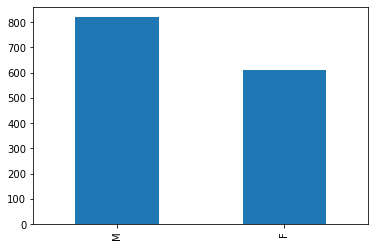

In [11]:
val_data['Patient Gender'].value_counts().plot(kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03869a6c10>]],
      dtype=object)

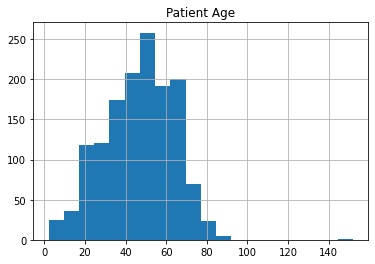

In [12]:
val_data.hist('Patient Age', bins = 20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0386811f10>]],
      dtype=object)

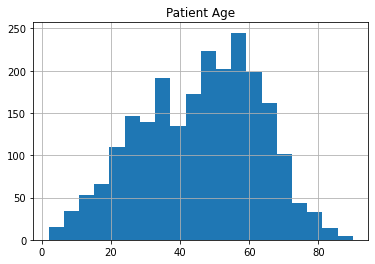

In [13]:
train_data = train_data[train_data['Patient Age'] < 100]
train_data.hist('Patient Age', bins = 20)

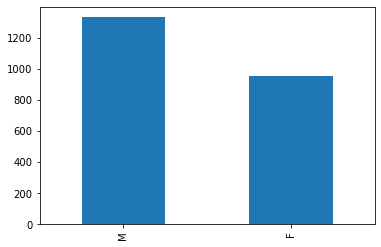

In [14]:
train_data['Patient Gender'].value_counts().plot(kind='bar')

In [15]:
train_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
77341,00018996_014.png,Infiltration|Pneumonia,14,18996,22,M,AP,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
109491,00029801_002.png,Infiltration|Pneumonia,2,29801,24,F,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
51693,00013052_011.png,Pneumonia|Pneumothorax,11,13052,41,F,PA,2738,2549,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Pneumonia
57089,00014177_007.png,Effusion|Pneumonia,7,14177,38,M,PA,2726,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
70982,00017504_060.png,Edema|Pneumonia,60,17504,12,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14112,00003658_002.png,No Finding,2,3658,15,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_pneumonia
92291,00023065_024.png,Effusion,24,23065,50,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia
46206,00011822_001.png,No Finding,1,11822,17,F,AP,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_pneumonia
77686,00019092_000.png,Atelectasis|Infiltration,0,19092,48,F,PA,2910,2712,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [16]:
IMG_SIZE = (224, 224)

In [20]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.4)
    
    return my_idg


def make_train_gen(idg):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    train_gen = idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 30
                                         )
    return train_gen


def make_val_gen():
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )
    val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 100
                                         )
    return val_gen

In [21]:
my_idg = my_image_augmentation()
train_gen = make_train_gen(my_idg)
val_gen = make_val_gen()

Found 2289 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [22]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

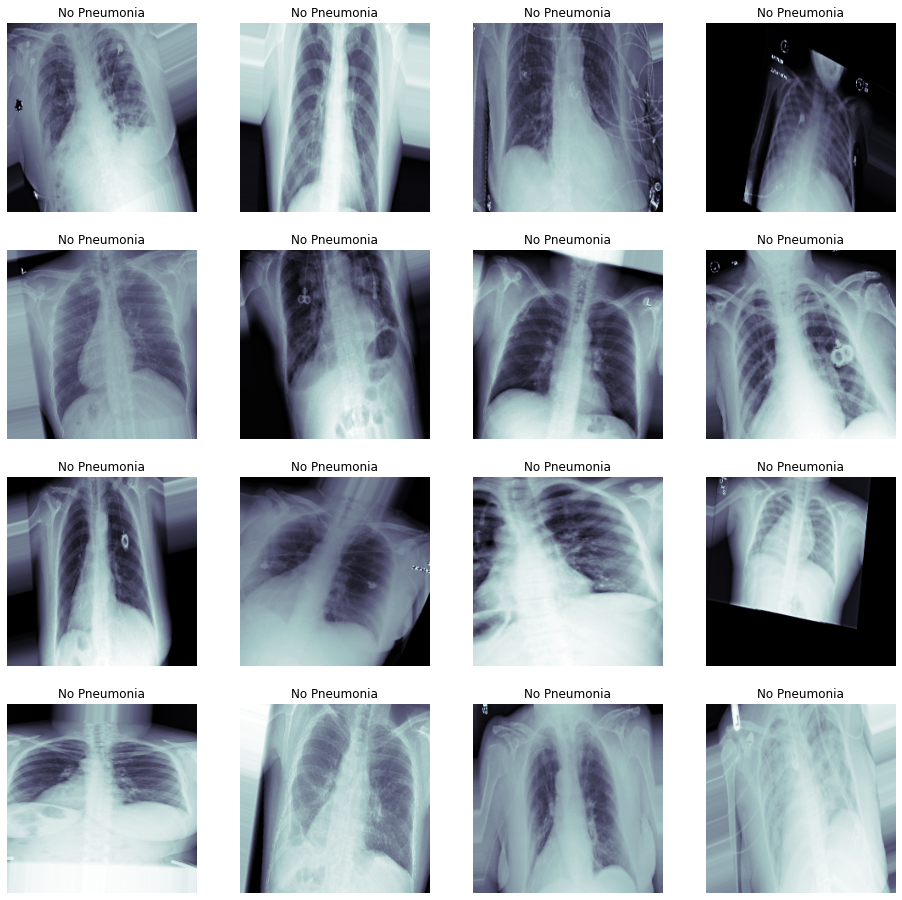

In [23]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 'Pneumonia':
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [24]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    return vgg_model


In [25]:
vgg_model = load_pretrained_model()
for layer in vgg_model.layers[0:17]:
    layer.trainable = False
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [31]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    my_model = Sequential()

    # Adding the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    my_model.add(Flatten())
    

    # Add a dense (aka. fully-connected) layer.
    # It is for combining features that the VGG16 model has recognized in the image.
    
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [32]:
## Set our optimizer, loss function, and learning rate
my_model = build_my_model()
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]


### Start training! 

In [36]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 20, 
                           callbacks = callbacks_list)

Epoch 1/20
77/77 [==============================] - 59s 764ms/step - loss: 0.6122 - binary_accuracy: 0.6553 - val_loss: 0.5608 - val_binary_accuracy: 0.7400

Epoch 00001: val_loss did not improve from 0.51854
Epoch 2/20
77/77 [==============================] - 58s 752ms/step - loss: 0.6044 - binary_accuracy: 0.6667 - val_loss: 0.5342 - val_binary_accuracy: 0.7300

Epoch 00002: val_loss did not improve from 0.51854
Epoch 3/20
77/77 [==============================] - 57s 744ms/step - loss: 0.6111 - binary_accuracy: 0.6723 - val_loss: 0.6661 - val_binary_accuracy: 0.6300

Epoch 00003: val_loss did not improve from 0.51854
Epoch 4/20
77/77 [==============================] - 57s 742ms/step - loss: 0.6055 - binary_accuracy: 0.6557 - val_loss: 0.5790 - val_binary_accuracy: 0.7100

Epoch 00004: val_loss did not improve from 0.51854
Epoch 5/20
77/77 [==============================] - 57s 744ms/step - loss: 0.6050 - binary_accuracy: 0.6763 - val_loss: 0.5614 - val_binary_accuracy: 0.7000

Epoch 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [38]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 1000, verbose = True)

100/100 [==============================] - 8s 81ms/step


In [43]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    


## what other performance statistics do you want to include here besides AUC? 

# function to plot the precision_recall_curve. We can utilize precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score here
def  calc_f1(prec,recall):
    return 2*((prec*recall)/(prec+recall)) if recall and prec else 0


    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
   


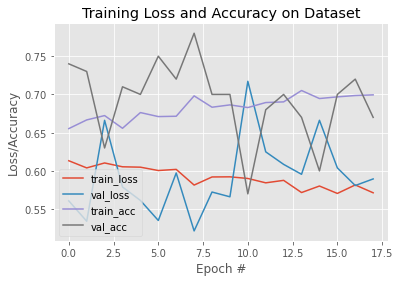

In [44]:
## plot figures

# Todo

plot_history(history)

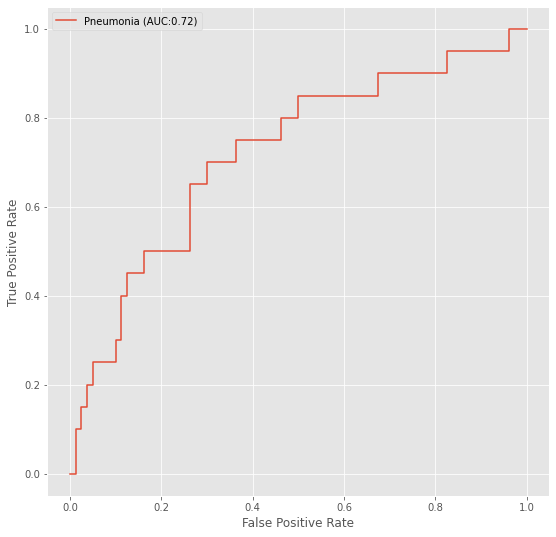

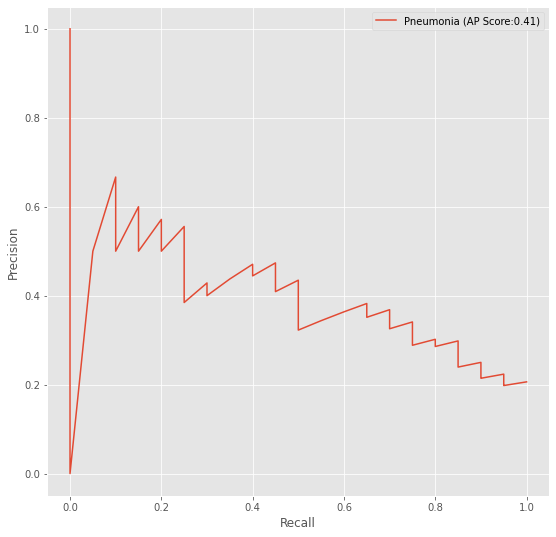

In [45]:
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [50]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
F1 = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(F1)
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(F1[idx]))


Precision: 0.3684210526315789
Recall: 0.7
Threshold: 0.38913885
F1 Score: 0.48275862068965514


In [47]:
F1 = np.delete(F1, -1)

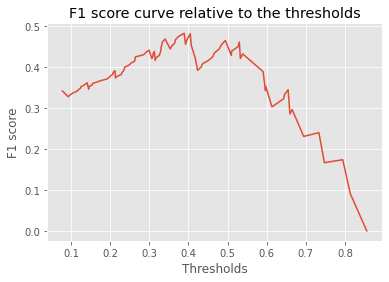

In [51]:
plt.plot(thresholds, F1)
plt.xlabel('Thresholds')
plt.ylabel('F1 score')
plt.title('F1 score curve relative to the thresholds')
plt.show()

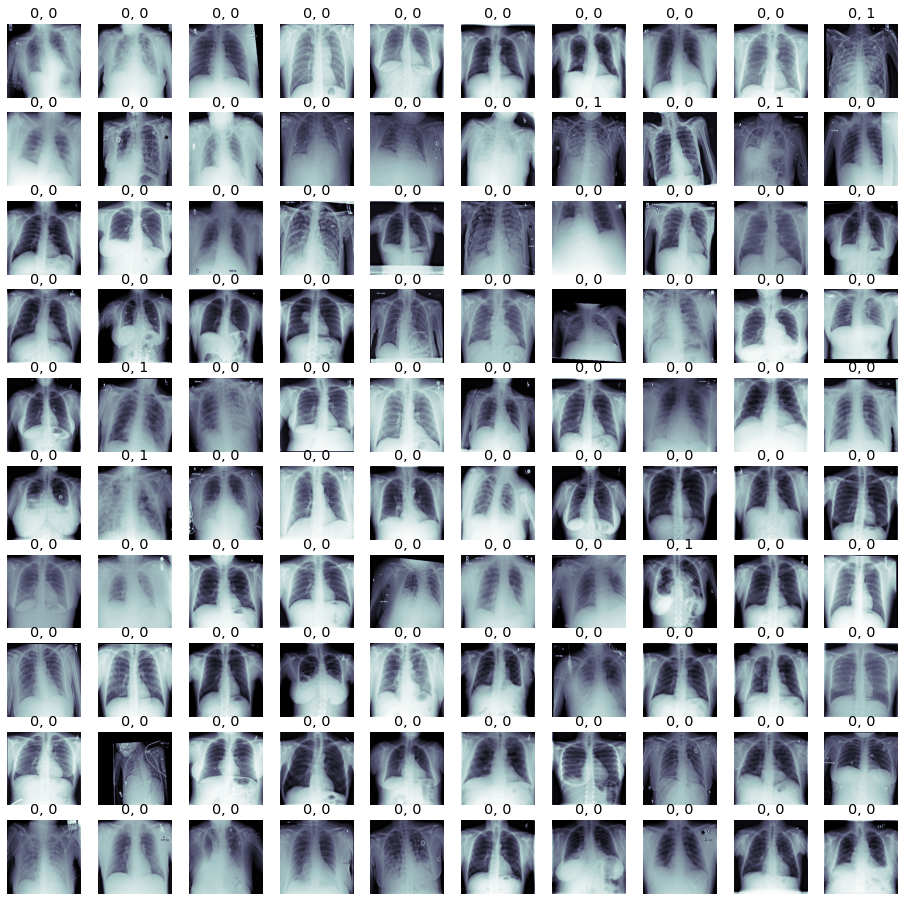

In [52]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 'pneumonia': 
        if pred_Y[:,0][i] > 0.68:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[:,0][i] > 0.68: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [53]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)